## Import Required Packages

In [ ]:
#install libraries

!rm -r kdg
!git clone https://github.com/neurodata/kdg
!ls
!pip install kdg/.

In [11]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from kdg.kdn import *
from kdg.utils import *

## Prepare dataset (Gaussian Sparse Parity)

In [12]:
# Define the experimental setup.
# We will be using a Gaussian sparse parity setup
# You can change these parameters.
# Higher than 10,000 training samples will take a prohibitively long time to run

p = 10  # total dimensions of the data vector
p_star = 2  # number of signal dimensions of the data vector

n_train = 2000
n_test = 1000

#XOR
X1, y1 = gaussian_sparse_parity(n_train, p_star=p_star, p=p)
X1_test, y1_test = gaussian_sparse_parity(n_test, p_star=p_star, p=p)

#XNOR
X2, y2 = gaussian_sparse_parity(n_train, p_star=p_star, p=p)
X2_test, y2_test = gaussian_sparse_parity(n_test, p_star=p_star, p=p)

y2 = -1*(y2-1)
y2_test = -1*(y2_test-1)

## Raw Neural Network

In [14]:
# Define our neural network parameters

def getNN(dense_size, input_size, **kwargs):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(input_size,)))
    network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**kwargs)
    return network_base

dense_layer_nodes = 5

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 150, "batch_size": 32, "verbose": False}


# Fit two neural networks using our test data and print accuracy
nn1 = getNN(dense_layer_nodes, p, **compile_kwargs)
nn1.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
y1_hat = np.argmax(nn1.predict(X1_test), axis=1)

print(f"NN1 Accuracy: {np.mean(y1_hat == y1_test)}")

nn2 = getNN(dense_layer_nodes, p, **compile_kwargs)
nn2.fit(X2, keras.utils.to_categorical(y2), **fit_kwargs)
y2_hat = np.argmax(nn2.predict(X2_test), axis=1)

print(f"NN2 Accuracy: {np.mean(y2_hat == y2_test)}")

y2_mismatch = np.argmax(nn1.predict(X2_test), axis=1)
print(f"NN1 Accuracy on X2 data: {np.mean(y2_mismatch == y2_test)}")

#Well that's garbage. Let's see if we can do better.

NN1 Accuracy: 0.932
NN2 Accuracy: 0.945
NN1 Accuracy on X2 data: 0.065


## Kernel Density Network Forward Transfer


### Test Functions

In [16]:
def forward_transfer(X, y, last_means, last_covs,
                     label_polytopes = False):
    r"""
    Re-assign labels, sizes to previous polytopes based on current data

    Parameters:
    -----------
    X: ndarray
        Input data matrix; training data for current task
    y : ndarray
        Output (i.e. response) data matrix for current task
    last_means: ndarray
        Means for previous polytopes
    last_covs: ndarray
        Covariances for previous polytopes

    Returns:
    ----------
    polytope_sizes : new sample counts for polytopes
    polytope_labels : new labels for polytopes
    """

    X = check_array(X)
    labels = np.unique(y)

    #likelihood = X_ members by nPolytopes
    likelihood = []

    # Edited from _compute_pdf
    # Get likelihoods for each pdf
    for polytope_idx in range(last_means.shape[0]):
        polytope_mean = last_means[polytope_idx]
        polytope_cov = last_covs[polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )
        
        likelihood.append(var.pdf(X))

    likelihood = np.array(likelihood)
    proba = np.argmax(likelihood, axis=0)
    proba_by_label = [proba[y == L] for L in labels]

    polytope_counts = np.zeros((labels.shape[0], last_means.shape[0]))
    for label in labels:
        polytope_idxs = np.unique(proba_by_label[label])
        for count, idx in enumerate(polytope_idxs):
            polytope_counts[label, idx] = np.sum(proba_by_label[label] == idx)
    
    if label_polytopes:
        polytope_sizes = np.max(polytope_counts, axis = 0)
        polytope_labels = np.argmax(polytope_counts, axis = 0)
        return polytope_sizes, polytope_labels

    else:
        polytope_sizes = polytope_counts
        return polytope_sizes


In [24]:
#Some KDN functions externalized for easier testing/editing
def _compute_pdf(X, polytope_id, polytope_means, polytope_covs):
    r"""compute the likelihood for the given data
    Parameters
    ----------
    X : ndarray
        Input data matrix
    label : int
        class label
    polytope_idx : int
        polytope identifier
    Returns
    -------
    ndarray
        likelihoods
    """
    polytope_mean = polytope_means[polytope_id]
    polytope_cov = polytope_covs[polytope_id]

    var = multivariate_normal(
        mean=polytope_mean, cov=polytope_cov, allow_singular=True
    )

    likelihood = var.pdf(X)
    return likelihood

def predict_proba2(X,
                   polytope_means,
                   polytope_covs,
                   polytope_sizes,
                   priors,
                   return_likelihoods=False):
    r"""
    Calculate posteriors using the kernel density forest.
    Parameters
    ----------
    X : ndarray
        Input data matrix.
    """
    X = check_array(X)

    labels = np.arange(0, polytope_sizes.shape[0])

    likelihoods = np.zeros((np.size(X, 0), len(labels)), dtype=float)
    priors = np.reshape(priors, (len(priors), 1))

    for label in labels:
        for polytope, size in enumerate(polytope_sizes[label, :]):
            likelihoods[:, label] += np.nan_to_num(
                size * _compute_pdf(X, polytope, polytope_means, polytope_covs)
            )

    proba = (
        likelihoods.T * priors / (np.sum(likelihoods * priors.T, axis=1) + 1e-100)
    ).T
    if return_likelihoods:
        return proba, likelihoods
    else:
        return proba

In [19]:
# Helper functions for testing

# Add noise to other shapes besides Gaussian sparse parity
def add_noise(X, p = 20, center_box = (-1.0, 1.0)):
    shape = X.shape

    X_noise = np.random.uniform(
        low=center_box[0], high=center_box[1], size=(X.shape[0], p - X.shape[1])
    )
    X = np.concatenate((X, X_noise), axis=1)

    return X

def test_forward_transfer(X, y, kdn, X_test = None, y_test = None, verbose = True):
    if X_test is None: X_test = X
    if y_test is None: y_test = y

    #flatten polytope information
    means = np.concatenate([val for (key, val) in kdn.polytope_means.items()])
    covs = np.concatenate([val for (key, val) in kdn.polytope_covs.items()])
    #labels_by_task = np.concatenate([np.ones(len(val))*key for (key, val) in kdn.polytope_means.items()])

    #test
    #sizes, labels = forward_transfer(X, y, means, covs)
    sizes = forward_transfer(X, y, means, covs)

    priors = []
    for label in np.unique(y_test):
        priors.append(np.sum(y_test == label))
    priors = priors/np.sum(priors)

    raw = np.argmax(nn1.predict(X_test), axis=1)
    raw_m = np.mean(raw == y_test)

    transfer = np.argmax(predict_proba2(X_test, means, covs, sizes, priors), axis = 1)
    transfer_m = np.mean(transfer == y_test)

    if verbose:
        print(f"NN Accuracy on X3 data without transfer: {raw_m}")
        print(f"NN Accuracy on X3 data after forward transfer: {transfer_m}")

    return raw_m, transfer_m

def plot_accuracy(sample_size, pct_errs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color_list = [(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]
    color_list.extend(sns.color_palette("Set1")[1:])

    for i, err in enumerate(pct_errs):
        ax.plot(sample_size, np.mean(err, axis=1), c=color_list[i], label=labels[i])
        ax.fill_between(
            sample_size,
            np.quantile(err, 0.25, axis=1),
            np.quantile(err, 0.75, axis=1),
            facecolor=color_list[i],
            alpha=0.3,
        )
    
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Percent Error")
    ax.legend(frameon=False)

### Test Algorithm

In [25]:
#Get initial KDN
kdn1 = kdn(network=nn1)
kdn1.fit(X1, y1)

#Test on new data
test_forward_transfer(X2, y2, kdn1)

NN Accuracy on X3 data without transfer: 0.057
NN Accuracy on X3 data after forward transfer: 0.947


(0.057, 0.947)

In [28]:
#Test fitting to ellipse

X3, y3 = generate_ellipse(n_test)
X3 = add_noise(X3, p)

#Try again
test_forward_transfer(X3, y3, kdn1)

NN Accuracy on X3 data without transfer: 0.49
NN Accuracy on X3 data after forward transfer: 0.612


(0.49, 0.612)

## Experiments

### XNOR Test

Testing with 100 samples
Task2 KDN Accuracy: [0.76, 0.76, 0.82, 0.67, 0.78, 0.76, 0.62, 0.73, 0.71, 0.74]
Task1 Accuracy on Task 2: [0.07, 0.09, 0.07, 0.08, 0.03, 0.06, 0.06, 0.07, 0.04, 0.04]
Forward Transfer Accuracy on Task 2: [0.83, 0.88, 0.88, 0.76, 0.82, 0.86, 0.8, 0.86, 0.85, 0.85]
Testing with 200 samples
Task2 KDN Accuracy: [0.76, 0.73, 0.78, 0.835, 0.76, 0.765, 0.835, 0.795, 0.855, 0.795]
Task1 Accuracy on Task 2: [0.055, 0.065, 0.065, 0.065, 0.045, 0.06, 0.07, 0.05, 0.05, 0.055]
Forward Transfer Accuracy on Task 2: [0.86, 0.865, 0.86, 0.87, 0.8, 0.825, 0.89, 0.89, 0.91, 0.885]
Testing with 300 samples
Task2 KDN Accuracy: [0.8433333333333334, 0.8466666666666667, 0.8766666666666667, 0.9033333333333333, 0.7966666666666666, 0.8, 0.8566666666666667, 0.8366666666666667, 0.7766666666666666, 0.8733333333333333]
Task1 Accuracy on Task 2: [0.043333333333333335, 0.03666666666666667, 0.04666666666666667, 0.06333333333333334, 0.05, 0.06333333333333334, 0.05333333333333334, 0.043333333333

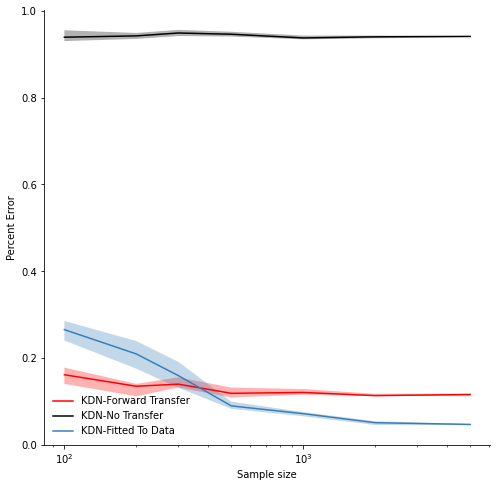

In [33]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = gaussian_sparse_parity(s, p_star = p_star, p = p)
        X_test, y_test = gaussian_sparse_parity(s, p_star=p_star, p=p)
        
        y_train = -1*(y_train-1)
        y_test = -1*(y_test-1)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### 45-Degree XOR

Testing with 100 samples
Task2 KDN Accuracy: [0.71, 0.68, 0.7, 0.6, 0.72, 0.76, 0.63, 0.72, 0.8, 0.76]
Task1 Accuracy on Task 2: [0.56, 0.57, 0.48, 0.6, 0.48, 0.59, 0.59, 0.54, 0.53, 0.47]
Forward Transfer Accuracy on Task 2: [0.83, 0.8, 0.77, 0.6, 0.64, 0.69, 0.63, 0.75, 0.55, 0.8]
Testing with 200 samples
Task2 KDN Accuracy: [0.875, 0.72, 0.75, 0.81, 0.735, 0.86, 0.8, 0.75, 0.81, 0.8]
Task1 Accuracy on Task 2: [0.5, 0.505, 0.525, 0.595, 0.52, 0.55, 0.505, 0.51, 0.465, 0.545]
Forward Transfer Accuracy on Task 2: [0.805, 0.63, 0.845, 0.89, 0.8, 0.765, 0.795, 0.8, 0.77, 0.83]
Testing with 300 samples
Task2 KDN Accuracy: [0.8866666666666667, 0.8366666666666667, 0.8733333333333333, 0.8633333333333333, 0.8466666666666667, 0.8833333333333333, 0.84, 0.8166666666666667, 0.85, 0.8866666666666667]
Task1 Accuracy on Task 2: [0.47, 0.5166666666666667, 0.51, 0.53, 0.5433333333333333, 0.5133333333333333, 0.57, 0.5033333333333333, 0.5133333333333333, 0.53]
Forward Transfer Accuracy on Task 2: [0.806

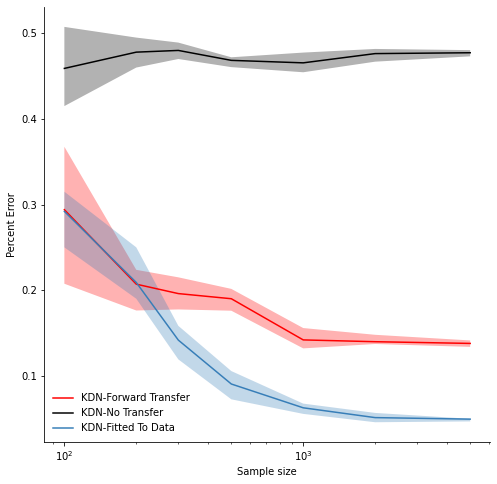

In [35]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_gaussian_parity(s, angle_params = np.pi/4)
        X_test, y_test = generate_gaussian_parity(s, angle_params = np.pi/4)

        X_train = add_noise(X_train, p)
        X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### Ellipse Test

Testing with 500 samples
Task2 KDN Accuracy: [0.578, 0.578, 0.606, 0.622, 0.602, 0.6, 0.574, 0.54, 0.534, 0.55]
Task1 Accuracy on Task 2: [0.488, 0.5, 0.508, 0.548, 0.508, 0.508, 0.516, 0.508, 0.508, 0.504]
Forward Transfer Accuracy on Task 2: [0.63, 0.634, 0.63, 0.644, 0.612, 0.638, 0.642, 0.592, 0.64, 0.556]
Testing with 1000 samples
Task2 KDN Accuracy: [0.606, 0.593, 0.619, 0.614, 0.6, 0.587, 0.619, 0.58, 0.655, 0.622]
Task1 Accuracy on Task 2: [0.508, 0.492, 0.527, 0.509, 0.518, 0.521, 0.491, 0.499, 0.485, 0.495]
Forward Transfer Accuracy on Task 2: [0.666, 0.656, 0.64, 0.663, 0.606, 0.633, 0.616, 0.618, 0.652, 0.645]
Testing with 2500 samples
Task2 KDN Accuracy: [0.656, 0.6408, 0.762, 0.704, 0.6548, 0.6972, 0.7272, 0.74, 0.6388, 0.6948]
Task1 Accuracy on Task 2: [0.4916, 0.49, 0.5172, 0.4836, 0.4812, 0.5188, 0.4976, 0.5048, 0.4876, 0.498]
Forward Transfer Accuracy on Task 2: [0.6572, 0.6672, 0.6472, 0.6488, 0.65, 0.6728, 0.6596, 0.632, 0.6504, 0.6732]
Testing with 5000 samples
Tas

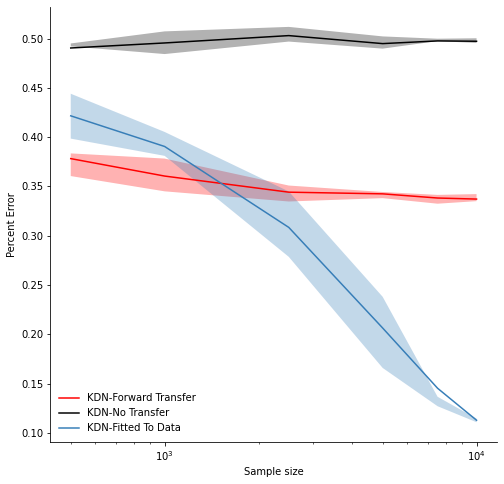

In [34]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [500, 1000, 2500, 5000, 7500, 10000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(5000, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_ellipse(s)
        X_test, y_test = generate_ellipse(s)

        X_train = add_noise(X_train, p)
        X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)